# 서비스 기획 _ 에이블리 뷰티 리뷰 분석
---

# 감성분석

## 1. 뷰티 언급 댓글 리뷰분석

In [16]:
import pandas as pd
beauty_filtered = pd.read_csv('./data/ably_beauty_filtered.csv')

### 토큰화 1: Kiwi

In [17]:
from kiwipiepy import Kiwi

kiwi = Kiwi()

In [18]:
def extract_keywords(text):
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos[0] in 'NV':
            yield f'{token}/{pos}'

In [19]:
def extract_keywords2(text):
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos[0] in 'NVM':
            yield f'{token}/{pos}'

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(max_features=500, tokenizer=extract_keywords)

In [21]:
dtm = cv.fit_transform(beauty_filtered['content'][:])
dtm

/Users/brielle/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<58x486 sparse matrix of type '<class 'numpy.int64'>'
	with 1267 stored elements in Compressed Sparse Row format>

In [22]:
trans = TfidfTransformer()
tf_idf = trans.fit_transform(dtm)
tf_idf

<58x486 sparse matrix of type '<class 'numpy.float64'>'
	with 1267 stored elements in Compressed Sparse Row format>

In [23]:
words = cv.get_feature_names_out()
words

array(['..리뷰/NNG', '가/VV', '가격/NNG', '가격대/NNG', '가능/NNG', '가방/NNG',
       '가성비/NNG', '가입/NNG', '가지/NNB', '간식/NNG', '감사/NNG', '강제/NNG',
       '같/VA', '개/NNB', '개/NNG', '개/VV', '개발자/NNG', '개편/NNG', '갯수/NNG',
       '거/NNB', '거/NP', '거기/NP', '걱정/NNG', '건/NNG', '걸리/VV', '것/NNB',
       '결국/NNG', '결제/NNG', '경우/NNG', '계산/NNG', '계정/NNG', '계정/NNP',
       '고/NNG', '고냥/NNG', '고려/NNG', '고민/NNG', '곳/NNG', '공감/NNG', '공구/NNG',
       '관계자/NNG', '관심/NNG', '광고/NNG', '괜찮/VA', '구경/NNG', '구매/NNG',
       '구매처/NNG', '구입/NNG', '굿즈/NNG', '궂/VA', '그거/NP', '그것/NP', '그러/VV',
       '그렇/VA', '금액/NNG', '기능/NNG', '기대/NNG', '기부/NNG', '기쁘/VA', '기존/NNG',
       '기한/NNG', '기획전/NNG', '깔/VV', '꺼/NNB', '꼽/VV-R', '꾸미/VV', '끊기/VV',
       '나/NP', '나/VV', '나/VX', '나누/VV', '나오/VV', '나이/NNG', '날짜/NNG',
       '남/VV', '남기/VV', '낮/VA', '내리/VV', '넘어가/VV', '넘조아요/NNG', '넘치/VV',
       '넣/VV', '놀랍/VA-I', '놓/VX', '누구/NP', '누르/VV', '눈물/NNG', '느리/VA',
       '늘리/VV', '늦/VA', '다그/VV', '다양/NNG', '다음/NNG', '다이어리/NNG',
       '다이어트/NN

In [24]:
tf_idf

<58x486 sparse matrix of type '<class 'numpy.float64'>'
	with 1267 stored elements in Compressed Sparse Row format>

#### 머신러닝

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

x = dtm
y = beauty_filtered['target']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# model.fit(X_train.A, y_train, epochs=10)
model.fit(X_train.A, y_train, epochs=10, validation_split=0.1,callbacks = [EarlyStopping(monitor='val_accuracy')])

2023-12-28 18:14:00.020714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2/2 [==============================] - 1s 607ms/step - loss: 0.6465 - accuracy: 0.6829 - val_loss: 0.6582 - val_accuracy: 0.8000
Epoch 2/10
2/2 [==============================] - 0s 120ms/step - loss: 0.6256 - accuracy: 0.7073 - val_loss: 0.6398 - val_accuracy: 0.8000


#### 가중치 및 키워드 확인

In [26]:
w,b = model.weights
word_sent = pd.DataFrame({'token':words,'weight':w.numpy().flat})
word_sent


,token,weight
0,..리뷰/NNG,-0.022836
1,가/VV,0.037359
2,가격/NNG,0.082657
3,가격대/NNG,0.091054
4,가능/NNG,0.015737
...,...,...
481,후/NNG,0.099219
482,후하/VA,-0.018017
483,후회/NNG,-0.066826
484,흘리/VV,-0.008854


In [27]:
word_sent.sort_values('weight',ascending=False).head(10)

,token,weight
233,세상/NNG,0.113625
55,기대/NNG,0.113500
389,주문/NNG,0.112251
464,하루/NNG,0.111352
121,등등/NNB,0.111266
172,바라/VV,0.109050
364,장난감/NNG,0.108741
314,오늘/NNG,0.108646
87,늘리/VV,0.108040
103,더럽/VA-I,0.107644


In [28]:
word_sent.sort_values('weight',ascending=False).tail(10)

,token,weight
404,징짜개마나여/NNG,-0.104713
399,직원/NNG,-0.105556
335,이내/NNG,-0.107466
339,이벤트/NNG,-0.107503
309,예/NNG,-0.107698
145,말/VX,-0.107796
291,어플/NNG,-0.108277
468,항상/NNG,-0.108359
83,누구/NP,-0.110614
334,이것저것/NNG,-0.113707


### 토큰화 2: Okt

In [29]:
import pandas as pd
from konlpy.tag import Okt

okt = Okt()
beauty_filtered = pd.read_csv('./data/ably_beauty_filtered.csv')

In [30]:
beauty_filtered['morphs'] = [okt.morphs(content) for content in beauty_filtered['content']]
beauty_filtered

,content,score,thumbsUpCount,at,year,month,target,morphs
0,친구가 추천해서 이용해봤는데 모든제품이 무료배송이고 명품도 있고 여러가지 제품들이 ...,5,0,2023-11-28 22:16:36,2023,11,1,"[친구, 가, 추천, 해서, 이용, 해봤는데, 모든, 제품, 이, 무료, 배송, 이..."
1,설치한지 며칠 안된 사람입니다. 솔직히 쇼핑을 잘 안 하다가 살게 있어서 한번 깔아...,5,0,2023-11-19 22:06:54,2023,11,1,"[설치, 한지, 며칠, 안된, 사람, 입니다, ., 솔직히, 쇼핑, 을, 잘, 안,..."
2,대한민국 여자들 필수앱... 올영보다 화장품이 더 싸고 쿠폰도 왕창 많이 뿌려서 너...,5,0,2023-08-26 01:20:20,2023,8,1,"[대한민국, 여자, 들, 필수, 앱, ..., 올, 영, 보다, 화장품, 이, 더,..."
3,좋아요 배송비없이 옷이며 화장품 다 살수있네요,5,0,2023-08-02 07:44:25,2023,8,1,"[좋아요, 배송비, 없이, 옷, 이며, 화장품, 다, 살수있네요]"
4,진짜 조아여 친구들이 진짜 안들어가면 사람아니라고 진짜 깔아야한다고 해서 처음 깔았...,5,0,2023-07-31 22:35:40,2023,7,1,"[진짜, 조아여, 친구, 들, 이, 진짜, 안, 들어가면, 사람, 아니라고, 진짜,..."
5,가격도 괜찮고 잘 보고 사면 좋은옷들 많아요 할인도 자주 해주고요 근데 상품정보 설...,3,0,2023-07-16 20:47:32,2023,7,1,"[가격, 도, 괜찮고, 잘, 보고, 사면, 좋은, 옷, 들, 많아요, 할인, 도, ..."
6,옷이 이쁘고 다양한 화장품도 있어 엄청 좋아요!! 추천합니당,5,0,2023-05-27 13:13:30,2023,5,1,"[옷, 이, 이쁘고, 다양한, 화장품, 도, 있어, 엄청, 좋아요, !!, 추천, ..."
7,너무 유명해서 되려 깔 마음이 없었는데 어쩌다 깔고 잘 쓰고 있어요. 단점이라면 옷...,4,0,2022-11-21 01:34:19,2022,11,1,"[너무, 유명해서, 되려, 깔, 마음, 이, 없었는데, 어쩌다, 깔고, 잘, 쓰고,..."
8,무료배송 쉽지않은데 대단하네요^.^. 항상 좋은 물건 좋은 화장품 편리하게 찾을수 ...,5,1,2022-11-12 15:55:42,2022,11,1,"[무료, 배송, 쉽지, 않은데, 대단하네요, ^.^., 항상, 좋은, 물건, 좋은,..."
9,"고2때부터 지금까지 계속 사용하던 유저입니다. 무료배송에다가 이쁜옷들,화장품 등등 ...",3,38,2022-10-24 16:37:58,2022,10,1,"[고, 2, 때, 부터, 지금, 까지, 계속, 사용, 하던, 유저, 입니다, ., ..."


#### 불용어 제거

In [31]:
# 불용어 목록
text = '~ ~~ ~~~ ~~~~ ~~~~~ ^ ^^ ! !! ㅜㅜ . .. , ,, 가 도 고 이나 요 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 입니다' 
stop_words = text.split(" ")
stop_words

['~',
 '~~',
 '~~~',
 '~~~~',
 '~~~~~',
 '^',
 '^^',
 '!',
 '!!',
 'ㅜㅜ',
 '.',
 '..',
 ',',
 ',,',
 '가',
 '도',
 '고',
 '이나',
 '요',
 '아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를',
 '들면',
 '예를',
 '들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수',
 '없다',
 '해서는',
 '안된다',
 '뿐만',
 '아니라',
 '만이',
 '아니다',
 '만은',
 '아니다',
 '막론하고',
 '관계없이',
 '그치지',
 '않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지',
 '않다',
 '따지지',
 '않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만',
 '못하다',
 '하는',
 '편이',
 '낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이',
 '외에',
 '이',
 '밖에',
 '하여야',
 '비로소',
 '한다면',
 '몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할',
 '생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게',
 '함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다

In [32]:
filtered = []
for idx,morphs in enumerate(beauty_filtered['morphs']):
    morphs_new = []
    for word in morphs:
        print(word)
        if word not in stop_words:
            morphs_new.append(word)
            beauty_filtered['morphs'][idx] = morphs_new
        else:
            pass

친구
가
추천
해서
이용
해봤는데
모든
제품
이
무료
배송
이고
명품
도
있고
여러가지
제품
들
이
많아서
필요한
옷
이나
화장품
등등
을
살수있어서
좋네요
😻
에이
블리
추천
합니다
설치
한지
며칠
안된
사람
입니다
.
솔직히
쇼핑
을
잘
안
하다가
살
게
있어서
한번
깔아
본건데
아직
까진
괜찮습니다
.
화장품
이건
옷
이건
더
다양하게
접
해서
그
런가
저
같은
사람
입장
에서는
신세계
네
요
.
대한민국
여자
들
필수
앱
...
올
영
보다
화장품
이
더
싸고
쿠폰
도
왕창
많이
뿌려서
너무
좋아요
ㅠㅠ
에이
블리
보세라서
싫다는
사람
들
도
많은데
에이블리
에
브랜드
도
있는거
알아줬으면
좋겠어요
..
리뷰
도
제
또래
들
이
쓴거라서
공감
되고
정말
정말
활발히
달리는
앱
이라
좋아요
!!
좋아요
배송비
없이
옷
이며
화장품
다
살수있네요
진짜
조아여
친구
들
이
진짜
안
들어가면
사람
아니라고
진짜
깔아야한
다
고
해서
처음
깔았었는데
로그인
간편해서
좋았어용
그리거
처음
들어가면
2000원
주고
그거
로
주문
하면
또
2000
원주고
할인
쿠폰
도
엄청
많고
여러
미션
도
많이
있어서
인터넷
쇼핑
처음
하는
저
로서
는
만족합니다
.
옷
들
도
이쁜거
많고
화장품
악세서리
간식
등등
여러
종류
에
물건
이
많아
구경
하다
보면
시간
후딱
가
기도
하고
ㅎ
옷
이랑
악
서리
간식
이
거
다
싸고
싼거에다가
할인
쿠폰
이랑
이
것
저
것
넣다
보면
2000
원
으로
사야하던게
0
원
이
되있습니다
진짜
처음
에
이
거
보고
눈물
흘릴
뻔
또
씨앗
심어서
포인트
(?)
암튼
그거
주는것도
있고
돼지
(?)
같은거
밥
주는것도
있고
여러가지
겜
같은것도
있어서
아주
기부
니
좋습니다
.
저
는
참고
로
초
짜
때
무료
로
반지
2
개
샀어여
(
ㅎ
)
토스
도
가능해서
편리하고
인터넷
쇼핑
앱
치고
아주
잼있게
사용
하고있습니다
열
분
고민
하기전에
까시고
고민
하십
쇼
\(^^)/
아
참
열
분
포인트
그거
모으는거는
광고
쪼오오끔
있어여
<(^^)/

/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_filtered['morphs'][idx] = morphs_new
/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_filtered['morphs'][idx] = morphs_new
/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

번호
누르면
이미
가입
된
계정
이
있다고
아이디
찾기
로
이동
되고
,
아이디
찾기
에서
전화번호
입력
을
하면
가입
된
계정
이
없다고
뜨네요
.
뭐
어쩌
라는
건지
...
재
가입
도
못
하고
로그인
도
못
하고
이도
저
도
아니게
돼
버렸네요
.
앱
지웠다
깔아도
똑같아요
.
어차피
저
화장품
밖에
안
사는데
에이
블
리가
무료
배송
에
쿠폰
도
자주
주고
가격
도
싸서
잘
썼는데
강제
로
못
쓰게
돼
버렸네요
.
리뷰
를
썼었는데
삭제
됐네요
ㅠㅠ
이
앱
정말
정말
추천
드려요
10
,
20
대
여성
분
이고
옷
에
관심
있거나
다이어리
꾸미기
화장
등
에
관심
있으시면
정말
유용하실
거
에요
장점
1
.
가격
,
색
등
을
설정
해
더
쉽게
찾아볼
수
있음
2
.
전
품목
무료
배송
임
3
.
여러
쇼핑몰
이
몰아져
있어서
가격
비교
를
하며
옷
을
살
수
있음
4
.
쿠폰
을
정말
많이
뿌려
줌
5
.
그냥
받으
삼
후회
할
일
없음
단점
1
.
다른
사람
이
단
리뷰
에
내
가
댓글
을
달
수
없음
2
.
단점
이
한
개
밖에
없음
아직
배송
안
받아
봐서
모르겠는데
풀랫폼자체
는
매우
괜춘함
.
옷
뿐
아니라
뷰티
템
들
도
쉽게
접근
가능한게
좋음
앱
에서
옷
뿐
만이
아니라
인스
,
스티커
,
케이스
,
화장품
등등
팔아서
좋은
것
같
애
요
!!
그리구
핸드폰
결제
말고
편의점
결제
도
가능해서
너무
너무
잘
쓰고
있어여
><
!
진짜
너무
조하요
ㅜㅜ
마켓
도
많고
취향
별로
가격
대
,
색
,
나이
,
키
등
많은
키
워드
가
있어서
너무
좋구요
쿠폰
도
많리
주고
이벤트
도
믾
이
해서
너무
너무
좋아요
ㅜㅜ
옷
,
화장품
은
다
에이블리
에서
구매
해요
정말
가성
비쩌
는
곳
은
여기
밖에
없을듯
15000원
짜리를
6
처넌
에
파는
곳
이
또
어디
있을까
;;;
에이
블리
관계자
님
샌시라는
화장품
브랜드
입점
시켜주세요
ㅠ
가성
비
좋은
옷
,
화장품
,
홈
데코
이쁜거
짱
많음
..
♡
다
좋은데
..
뷰티
상품
이
좀더
많았

/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_filtered['morphs'][idx] = morphs_new
/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_filtered['morphs'][idx] = morphs_new
/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/4092838277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [33]:
beauty_filtered

,content,score,thumbsUpCount,at,year,month,target,morphs
0,친구가 추천해서 이용해봤는데 모든제품이 무료배송이고 명품도 있고 여러가지 제품들이 ...,5,0,2023-11-28 22:16:36,2023,11,1,"[친구, 추천, 해서, 이용, 해봤는데, 모든, 제품, 무료, 배송, 이고, 명품,..."
1,설치한지 며칠 안된 사람입니다. 솔직히 쇼핑을 잘 안 하다가 살게 있어서 한번 깔아...,5,0,2023-11-19 22:06:54,2023,11,1,"[설치, 한지, 며칠, 안된, 솔직히, 쇼핑, 하다가, 게, 있어서, 한번, 깔아,..."
2,대한민국 여자들 필수앱... 올영보다 화장품이 더 싸고 쿠폰도 왕창 많이 뿌려서 너...,5,0,2023-08-26 01:20:20,2023,8,1,"[대한민국, 필수, 앱, ..., 올, 보다, 화장품, 싸고, 쿠폰, 왕창, 많이,..."
3,좋아요 배송비없이 옷이며 화장품 다 살수있네요,5,0,2023-08-02 07:44:25,2023,8,1,"[좋아요, 배송비, 없이, 옷, 이며, 화장품, 다, 살수있네요]"
4,진짜 조아여 친구들이 진짜 안들어가면 사람아니라고 진짜 깔아야한다고 해서 처음 깔았...,5,0,2023-07-31 22:35:40,2023,7,1,"[진짜, 조아여, 친구, 진짜, 들어가면, 아니라고, 진짜, 깔아야한, 다, 해서,..."
5,가격도 괜찮고 잘 보고 사면 좋은옷들 많아요 할인도 자주 해주고요 근데 상품정보 설...,3,0,2023-07-16 20:47:32,2023,7,1,"[가격, 괜찮고, 보고, 사면, 좋은, 옷, 많아요, 할인, 자주, 해주고요, 근데..."
6,옷이 이쁘고 다양한 화장품도 있어 엄청 좋아요!! 추천합니당,5,0,2023-05-27 13:13:30,2023,5,1,"[옷, 이쁘고, 다양한, 화장품, 있어, 엄청, 좋아요, 추천, 합니당]"
7,너무 유명해서 되려 깔 마음이 없었는데 어쩌다 깔고 잘 쓰고 있어요. 단점이라면 옷...,4,0,2022-11-21 01:34:19,2022,11,1,"[너무, 유명해서, 되려, 깔, 마음, 없었는데, 어쩌다, 깔고, 쓰고, 있어요, ..."
8,무료배송 쉽지않은데 대단하네요^.^. 항상 좋은 물건 좋은 화장품 편리하게 찾을수 ...,5,1,2022-11-12 15:55:42,2022,11,1,"[무료, 배송, 쉽지, 않은데, 대단하네요, ^.^., 항상, 좋은, 물건, 좋은,..."
9,"고2때부터 지금까지 계속 사용하던 유저입니다. 무료배송에다가 이쁜옷들,화장품 등등 ...",3,38,2022-10-24 16:37:58,2022,10,1,"[2, 계속, 사용, 하던, 유저, 무료, 배송, 에다가, 이쁜, 옷, 화장품, 맘..."


#### DTM 생성

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer()

beauty_filtered['morphs2'] = beauty_filtered['morphs'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
dtm = cv.fit_transform(beauty_filtered['morphs2'])
dtm

<58x760 sparse matrix of type '<class 'numpy.int64'>'
	with 1242 stored elements in Compressed Sparse Row format>

#### 모델 학습

In [35]:
from sklearn.model_selection import train_test_split

x = dtm
y = beauty_filtered['target']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# model.fit(X_train.A, y_train, epochs=10)

history = model.fit(X_train.A, y_train, epochs=100, validation_split=0.1)

Epoch 1/100


2/2 [==============================] - 1s 680ms/step - loss: 0.6538 - accuracy: 0.6585 - val_loss: 0.6482 - val_accuracy: 0.8000
Epoch 2/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6347 - accuracy: 0.7073 - val_loss: 0.6392 - val_accuracy: 0.8000
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 0.6181 - accuracy: 0.7317 - val_loss: 0.6306 - val_accuracy: 0.8000
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6028 - accuracy: 0.7561 - val_loss: 0.6222 - val_accuracy: 0.8000
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.5876 - accuracy: 0.7805 - val_loss: 0.6140 - val_accuracy: 0.8000
Epoch 6/100
2/2 [==============================] - 0s 47ms/step - loss: 0.5728 - accuracy: 0.8293 - val_loss: 0.6061 - val_accuracy: 0.8000
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.5592 - accuracy: 0.8293 - val_loss: 0.5984 - val_accuracy: 0.8000
Epoch 8/100
2/2 [==============

#### 모델 검증

In [37]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



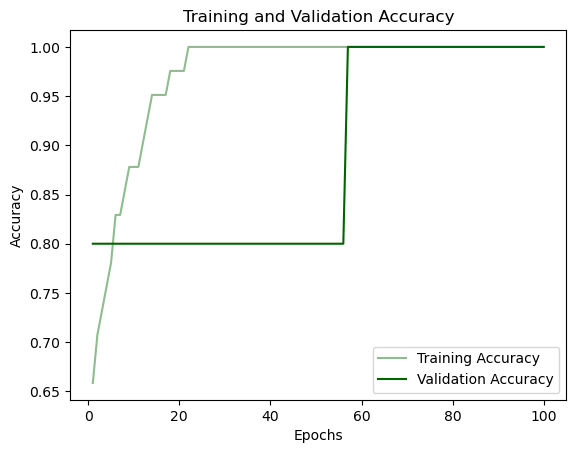

In [38]:
plt.clf()       #그래프 초기화

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='Training Accuracy', color='darkseagreen')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='darkgreen')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

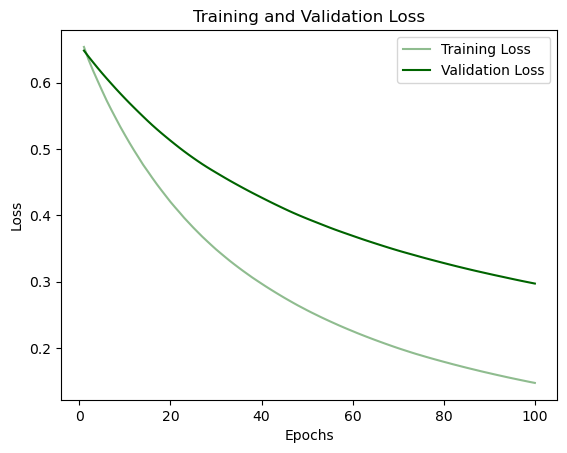

In [39]:
plt.clf()       #그래프 초기화

epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, label='Training Loss', color='darkseagreen')
plt.plot(epochs, val_loss, label='Validation Loss', color='darkgreen')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 최종 모델 선택

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train.A, y_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 249ms/step - loss: 0.6945 - accuracy: 0.4783
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6572 - accuracy: 0.5435
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6406 - accuracy: 0.6087
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.6739
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6084 - accuracy: 0.7174
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5934 - accuracy: 0.7609
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.7826
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5651 - accuracy: 0.8261
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5516 - accuracy: 0.8696
Epoch 11/20
2/2 [====================

## 2020~ 리뷰 분석

### 데이터 준비

In [41]:
import pandas as pd

yearly = pd.read_csv('./data/ably_yearly.csv')
yearly.head()

,content,score,thumbsUpCount,at,year,month,target
0,( ´͈ ᵕ `͈ )◞♡,5,0,2023-12-27 10:26:27,2023,12,1
1,구매했는데 배송 안되길래 봤더니 취소 진행중이더라구요?? 아니 품절된 상품이면 구매...,1,0,2023-12-27 08:52:56,2023,12,0
2,품질 좋고 가격 저렴해요 가성비 멋져버려요,5,0,2023-12-26 22:49:53,2023,12,1
3,40대에도 쇼핑할수있는 폭이 넓어 좋습니다,5,0,2023-12-26 21:13:51,2023,12,1
4,좋아용,5,0,2023-12-26 16:39:20,2023,12,1


### 전처리

In [42]:
yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21936 entries, 0 to 21935
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        21936 non-null  object
 1   score          21936 non-null  int64 
 2   thumbsUpCount  21936 non-null  int64 
 3   at             21936 non-null  object
 4   year           21936 non-null  int64 
 5   month          21936 non-null  int64 
 6   target         21936 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.2+ MB


* 2020년 이후 리뷰만 필터링

In [43]:
yearly_filtered = yearly[yearly['year'] >= 2020]
yearly_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16005 entries, 0 to 16004
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        16005 non-null  object
 1   score          16005 non-null  int64 
 2   thumbsUpCount  16005 non-null  int64 
 3   at             16005 non-null  object
 4   year           16005 non-null  int64 
 5   month          16005 non-null  int64 
 6   target         16005 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1000.3+ KB


#### 토큰화

In [44]:
from konlpy.tag import Okt
okt = Okt()

yearly_filtered['morphs'] = [okt.morphs(content) for content in yearly_filtered['content']]
yearly_filtered

/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/1356793752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_filtered['morphs'] = [okt.morphs(content) for content in yearly_filtered['content']]


,content,score,thumbsUpCount,at,year,month,target,morphs
0,( ´͈ ᵕ `͈ )◞♡,5,0,2023-12-27 10:26:27,2023,12,1,"[(, ´͈, ᵕ, `, ͈, ), ◞♡]"
1,구매했는데 배송 안되길래 봤더니 취소 진행중이더라구요?? 아니 품절된 상품이면 구매...,1,0,2023-12-27 08:52:56,2023,12,0,"[구매, 했는데, 배송, 안되길래, 봤더니, 취소, 진행중, 이, 더라구요, ??,..."
2,품질 좋고 가격 저렴해요 가성비 멋져버려요,5,0,2023-12-26 22:49:53,2023,12,1,"[품질, 좋고, 가격, 저렴해요, 가성, 비, 멋져, 버려요]"
3,40대에도 쇼핑할수있는 폭이 넓어 좋습니다,5,0,2023-12-26 21:13:51,2023,12,1,"[40, 대에도, 쇼핑, 할수있는, 폭, 이, 넓어, 좋습니다]"
4,좋아용,5,0,2023-12-26 16:39:20,2023,12,1,[좋아용]
...,...,...,...,...,...,...,...,...
16000,감사,5,0,2020-01-01 03:41:37,2020,1,1,[감사]
16001,굿입니다,4,0,2020-01-01 03:27:01,2020,1,1,"[굿, 입니다]"
16002,옷도예쁘고.우선받아봐야알겠지만.한눈에볼수있어서좋아요,4,0,2020-01-01 02:44:32,2020,1,1,"[옷, 도, 예쁘고, ., 우선, 받아, 봐야, 알겠지만, ., 한눈, 에, 볼수있..."
16003,조아요,5,0,2020-01-01 02:13:58,2020,1,1,[조아요]


#### 불용어 처리

In [45]:
# 불용어 목록
text = '~ ~~ ~~~ ~~~~ ~~~~~ ^ ^^ ! !! ㅜㅜ . .. , ,, 가 도 고 이나 요 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 입니다' 
stop_words = text.split(" ")
stop_words

['~',
 '~~',
 '~~~',
 '~~~~',
 '~~~~~',
 '^',
 '^^',
 '!',
 '!!',
 'ㅜㅜ',
 '.',
 '..',
 ',',
 ',,',
 '가',
 '도',
 '고',
 '이나',
 '요',
 '아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를',
 '들면',
 '예를',
 '들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수',
 '없다',
 '해서는',
 '안된다',
 '뿐만',
 '아니라',
 '만이',
 '아니다',
 '만은',
 '아니다',
 '막론하고',
 '관계없이',
 '그치지',
 '않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지',
 '않다',
 '따지지',
 '않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만',
 '못하다',
 '하는',
 '편이',
 '낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이',
 '외에',
 '이',
 '밖에',
 '하여야',
 '비로소',
 '한다면',
 '몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할',
 '생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게',
 '함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다

In [46]:
stop_words_set = set(stop_words)
yearly_filtered['morphs'] = [
    [word for word in morphs if word not in stop_words_set]
    for morphs in yearly_filtered['morphs']
]

/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/481170780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_filtered['morphs'] = [


#### DTM

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer()

yearly_filtered['morphs'] = yearly_filtered['morphs'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
dtm = cv.fit_transform(yearly_filtered['morphs'])
dtm

/var/folders/y6/tjfrq8vj411cyf6zll2ppq_w0000gn/T/ipykernel_995/936669968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_filtered['morphs'] = yearly_filtered['morphs'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


<16005x17119 sparse matrix of type '<class 'numpy.int64'>'
	with 124627 stored elements in Compressed Sparse Row format>

### 모델 학습

In [48]:
from sklearn.model_selection import train_test_split

x = dtm
y = yearly_filtered['target']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train.A, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
321/321 [==============================] - 5s 14ms/step - loss: 0.5648 - accuracy: 0.8834 - val_loss: 0.4760 - val_accuracy: 0.8907
Epoch 2/20
321/321 [==============================] - 2s 6ms/step - loss: 0.4134 - accuracy: 0.9066 - val_loss: 0.3822 - val_accuracy: 0.8973
Epoch 3/20
321/321 [==============================] - 2s 6ms/step - loss: 0.3314 - accuracy: 0.9181 - val_loss: 0.3274 - val_accuracy: 0.9008
Epoch 4/20
321/321 [==============================] - 2s 6ms/step - loss: 0.2793 - accuracy: 0.9247 - val_loss: 0.2927 - val_accuracy: 0.9043
Epoch 5/20
321/321 [==============================] - 2s 6ms/step - loss: 0.2434 - accuracy: 0.9311 - val_loss: 0.2694 - val_accuracy: 0.9067
Epoch 6/20
321/321 [==============================] - 2s 5ms/step - loss: 0.2171 - accuracy: 0.9355 - val_loss: 0.2530 - val_accuracy: 0.9051
Epoch 7/20
321/321 [==============================] - 2s 5ms/step - loss: 0.1971 - accuracy: 0.9401 - val_loss: 0.2412 - val_accuracy: 0.9063
Epoch

#### 모델 검증

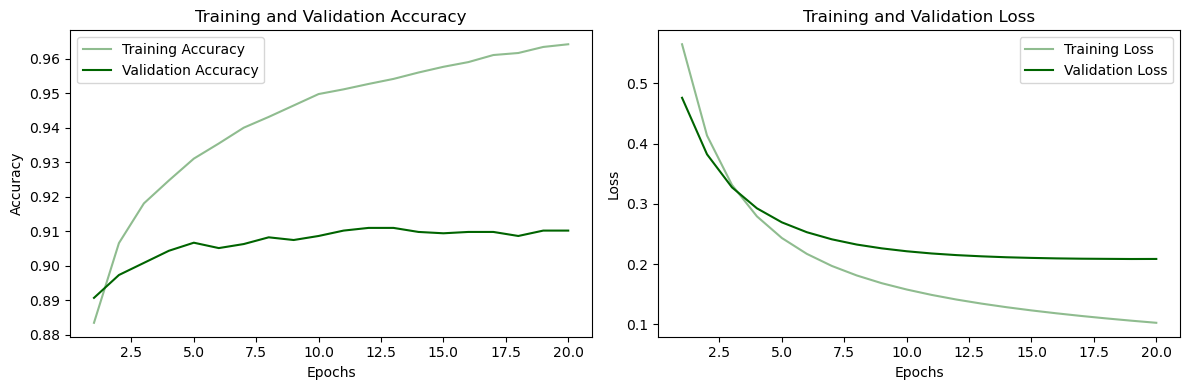

In [50]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
epochs = range(1, len(acc)+1)
axes[0].plot(epochs, acc, label='Training Accuracy', color='darkseagreen')
axes[0].plot(epochs, val_acc, label='Validation Accuracy', color='darkgreen')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, label='Training Loss', color='darkseagreen')
axes[1].plot(epochs, val_loss, label='Validation Loss', color='darkgreen')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


#### 최종 모델 선택

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train.A, y_train, epochs=5,validation_split=0.2)

Epoch 1/5
321/321 [==============================] - 3s 8ms/step - loss: 0.5693 - accuracy: 0.8786 - val_loss: 0.4784 - val_accuracy: 0.8934
Epoch 2/5
321/321 [==============================] - 1s 4ms/step - loss: 0.4158 - accuracy: 0.9079 - val_loss: 0.3831 - val_accuracy: 0.8965
Epoch 3/5
321/321 [==============================] - 2s 5ms/step - loss: 0.3332 - accuracy: 0.9178 - val_loss: 0.3282 - val_accuracy: 0.9039
Epoch 4/5
321/321 [==============================] - 1s 4ms/step - loss: 0.2806 - accuracy: 0.9259 - val_loss: 0.2932 - val_accuracy: 0.9043
Epoch 5/5
321/321 [==============================] - 2s 5ms/step - loss: 0.2444 - accuracy: 0.9304 - val_loss: 0.2696 - val_accuracy: 0.9063


## 대규모 데이터로 훈련시킨 모델로 뷰티 언급 리뷰 감성분석

### 전처리 및 토큰화 함수로 정리하기

#### 데이터셋 정리

In [14]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

okt = Okt()

In [6]:


beauty_df = pd.read_csv('./data/ably_beauty_filtered.csv')
yearly_df = pd.read_csv('./data/ably_yearly.csv')


In [7]:
beauty_df = beauty_df[['content','target']]
yearly_df = yearly_df[['content','target']]

In [8]:
# 2020년 이후 리뷰 전체에서 뷰티 언급 리뷰 제거
print(len(yearly_df))
yearly_df = yearly_df[~yearly_df['content'].isin(beauty_df['content'])]
print(len(yearly_df))

21936
21878


In [15]:
def tokenize(dataFrame):
    dataFrame['morphs'] = [okt.morphs(content) for content in dataFrame['content']]
    return dataFrame

def remove_stop_words(dataFrame):
    text = '~ ~~ ~~~ ~~~~ ~~~~~ ^ ^^ ! !! ㅜㅜ . .. , ,, 가 도 고 이고 이나 요 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 입니다' 
    stop_words = text.split(" ")
    stop_words_set = set(stop_words)
    dataFrame['morphs'] = [[word for word in morphs if word not in stop_words_set] for morphs in dataFrame['morphs']]
    return dataFrame

def dtm_maker(dataFrame):
    cv = CountVectorizer(max_features=800)
    dataFrame['morphs'] = dataFrame['morphs'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    dtm = cv.fit_transform(dataFrame['morphs'])
    return dtm

def data_preprocessing(dataFrame):
    tokenize(dataFrame)
    remove_stop_words(dataFrame)
    dtm = dtm_maker(dataFrame)   
    return dataFrame,dtm

beauty_preprocessed, beauty_dtm = data_preprocessing(beauty_df)
yearly_preprocessed, yearly_dtm = data_preprocessing(yearly_df)

### 머신러닝

In [30]:
X_train = yearly_dtm
y_train = yearly_preprocessed['target']
X_test = beauty_dtm
y_test = beauty_preprocessed['target']

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train.A, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
547/547 [==============================] - 3s 3ms/step - loss: 0.5199 - accuracy: 0.8773 - val_loss: 0.4479 - val_accuracy: 0.8515
Epoch 2/20
547/547 [==============================] - 1s 2ms/step - loss: 0.3557 - accuracy: 0.9057 - val_loss: 0.3660 - val_accuracy: 0.8604
Epoch 3/20
547/547 [==============================] - 1s 2ms/step - loss: 0.2860 - accuracy: 0.9109 - val_loss: 0.3268 - val_accuracy: 0.8663
Epoch 4/20
547/547 [==============================] - 1s 2ms/step - loss: 0.2491 - accuracy: 0.9141 - val_loss: 0.3057 - val_accuracy: 0.8672
Epoch 5/20
547/547 [==============================] - 1s 2ms/step - loss: 0.2272 - accuracy: 0.9160 - val_loss: 0.2933 - val_accuracy: 0.8679
Epoch 6/20
547/547 [==============================] - 1s 2ms/step - loss: 0.2133 - accuracy: 0.9178 - val_loss: 0.2859 - val_accuracy: 0.8697
Epoch 7/20
547/547 [==============================] - 1s 2ms/step - loss: 0.2039 - accuracy: 0.9196 - val_loss: 0.2811 - val_accuracy: 0.8716
Epoch 

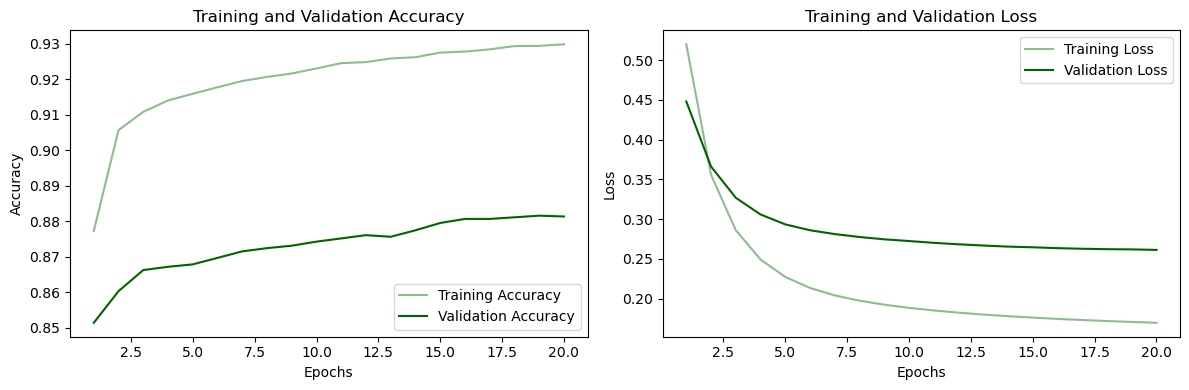

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
epochs = range(1, len(acc)+1)

axes[0].plot(epochs, acc, label='Training Accuracy', color='darkseagreen')
axes[0].plot(epochs, val_acc, label='Validation Accuracy', color='darkgreen')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, label='Training Loss', color='darkseagreen')
axes[1].plot(epochs, val_loss, label='Validation Loss', color='darkgreen')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


## 최종 모델 선택

In [35]:
final_model = Sequential()
final_model.add(Dense(1,activation='sigmoid'))
final_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

final_model.fit(X_train.A, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
547/547 [==============================] - 2s 2ms/step - loss: 0.5208 - accuracy: 0.8776 - val_loss: 0.4496 - val_accuracy: 0.8476
Epoch 2/5
547/547 [==============================] - 1s 2ms/step - loss: 0.3564 - accuracy: 0.9051 - val_loss: 0.3665 - val_accuracy: 0.8581
Epoch 3/5
547/547 [==============================] - 1s 2ms/step - loss: 0.2865 - accuracy: 0.9100 - val_loss: 0.3267 - val_accuracy: 0.8643
Epoch 4/5
547/547 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.9130 - val_loss: 0.3052 - val_accuracy: 0.8668
Epoch 5/5
547/547 [==============================] - 1s 2ms/step - loss: 0.2274 - accuracy: 0.9156 - val_loss: 0.2929 - val_accuracy: 0.8675


In [36]:
final_model.save('./data/final_model_20231228.h5')

/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
from tensorflow.keras.models import load_model
final_model = load_model('./data/final_model_20231228.h5')

In [43]:
import tensorflow as tf
from scipy.sparse import csr_matrix

def convert_sparse_matrix_to_sparse_tensor(sparse_matrix):
    coo = sparse_matrix.tocoo()
    indices = tf.constant(list(zip(coo.row, coo.col)), dtype=tf.int64)
    values = tf.constant(coo.data, dtype=tf.float32)
    shape = tf.constant(coo.shape, dtype=tf.int64)
    return tf.SparseTensor(indices, values, shape)

In [44]:
beauty_sparse = convert_sparse_matrix_to_sparse_tensor(beauty_dtm)
yearly_sparse = convert_sparse_matrix_to_sparse_tensor(yearly_dtm)

beauty_sparse = tf.sparse.reorder(beauty_sparse)
yearly_sparse = tf.sparse.reorder(yearly_sparse)

In [45]:
X_test = beauty_sparse
y_test = beauty_preprocessed['target']

In [42]:
type(beauty_dtm)

scipy.sparse._csr.csr_matrix

In [48]:
# Convert sparse tensor to dense tensor
X_test_dense = tf.sparse.to_dense(X_test)

# Ensure y_test is in a suitable format, e.g., NumPy array
y_test_numpy = y_test.values

# Evaluate the model
loss_and_metrics = model.evaluate(X_test_dense, y_test_numpy, batch_size=32)

print('## evaluation loss and_metrics ##')
print(loss_and_metrics)


ValueError: in user code:

    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/brielle/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 800, but received input with shape (None, 759)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 759), dtype=float32)
      • training=False
      • mask=None
